In [1]:
!pip install torchvision==0.16.0
!pip install seaborn
# 安装后点击上方 Restart the kernal

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.huaweicloud.com/repository/pypi/simple

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.huaweicloud.com/repository/pypi/simple

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# 步骤一：导入相关库
import os
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms
from torch_npu.contrib import transfer_to_npu
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

/home/service/.local/lib/python3.10/site-packages/torch_npu/utils/path_manager.py:82: UserWarning: Warning: The /usr/local/Ascend/ascend-toolkit/latest owner does not match the current user.
  warnings.warn(f"Warning: The {path} owner does not match the current user.")
/home/service/.local/lib/python3.10/site-packages/torch_npu/utils/path_manager.py:82: UserWarning: Warning: The /usr/local/Ascend/ascend-toolkit/8.0.RC3/aarch64-linux/ascend_toolkit_install.info owner does not match the current user.
  warnings.warn(f"Warning: The {path} owner does not match the current user.")
/home/service/.local/lib/python3.10/site-packages/torch_npu/contrib/transfer_to_npu.py:301: ImportWarning: 
    *************************************************************************************************************
    The torch.Tensor.cuda and torch.nn.Module.cuda are replaced with torch.Tensor.npu and torch.nn.Module.npu now..
    The torch.cuda.DoubleTensor is replaced with torch.npu.FloatTensor cause th

In [3]:
# 步骤二：加载数据集
# 2.1 设置超参数
EPOCH = 30
BATCH_SIZE = 64
LR = 0.003
DOWNLOAD_CIFAR = False
DEVICE = 'npu'

# 2.2 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 2.3 检查是否需要下载数据集
if not(os.path.exists('./cifar/')) or not os.listdir('./cifar/'):
    DOWNLOAD_CIFAR = True

# 2.4 加载训练集和测试集
train_data = torchvision.datasets.CIFAR10(
    root='./cifar/',
    train=True,
    transform=transform,
    download=DOWNLOAD_CIFAR
)
test_data = torchvision.datasets.CIFAR10(
    root='./cifar/',
    train=False,
    transform=transform,
    download=DOWNLOAD_CIFAR
)

# 2.5 封装数据加载器
train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = Data.DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

In [4]:
# 步骤三：CNN模型设计
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            # 第一卷积块 [1,5](@ref)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 输入通道3，输出32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 输出尺寸16x16
            
            # 第二卷积块 [2,6](@ref)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)   # 输出尺寸8x8
        )
        self.fc = nn.Sequential(
            nn.Flatten(),  # 将特征图展平 [5,7](@ref)
            nn.Linear(64 * 8 * 8, 512),  # 输入维度计算：64通道*8x8特征图
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # 防止过拟合 [9,10](@ref)
            nn.Linear(512, 10)  # 输出10分类
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# 3.2 实例化模型并迁移到设备
# 动态判断并设置设备
# 确保 torch_npu 已经正确安装并在环境中生效
if hasattr(torch, 'npu') and torch.npu.is_available():
    device = torch.device('npu:0')
    print("NPU设备可用，正在使用NPU:0")
elif torch.cuda.is_available(): # 作为一个备选，如果NPU不可用但有GPU
    device = torch.device('cuda:0')
    print("CUDA设备可用，正在使用CUDA:0")
else:
    device = torch.device('cpu')
    print("NPU和CUDA设备均不可用，正在使用CPU")

# 3.2 实例化模型并迁移到设备
cnn = CNN().to(device) # 直接将 device 变量传递给 .to()
print(cnn)

NPU设备可用，正在使用NPU:0


[W compiler_depend.ts:623] Warning: expandable_segments currently defaults to false. You can enable this feature by `export PYTORCH_NPU_ALLOC_CONF = expandable_segments:True`. (function operator())


CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
# 步骤四：设置损失函数与优化器
optimizer = torch.optim.Adam(
    cnn.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    eps=1e-08
)  # 请在此处编写代码：Adam优化器
criterion = nn.CrossEntropyLoss()  # 请在此处编写代码：交叉熵损失

In [6]:
# 步骤五：训练模型
train_losses = []
test_accuracies = []

# 5.1 定义训练函数
def train(epoch):
    cnn.train()  # 切换到训练模式
    epoch_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        # 数据迁移到NPU设备
        inputs = inputs.to(device) # <-- 这里修改
        targets = targets.to(device) # <-- 这里修改
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 前向传播
        outputs = cnn(inputs)
        
        # 计算损失
        loss = criterion(outputs, targets)
        
        # 反向传播
        loss.backward()
        
        # 参数更新
        optimizer.step()
        
        # 累计损失（乘以batch_size以正确计算平均）
        epoch_loss += loss.item() * inputs.size(0)
        
        # 每100批次打印中间结果
        if batch_idx % 100 == 0:
            batch_loss = loss.item() * inputs.size(0) / BATCH_SIZE
            print(f"\nBatch [{batch_idx}] Loss: {batch_loss:.4f}")

    # 计算epoch平均损失（考虑可能的不完整批次）
    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}] Average Train Loss: {avg_epoch_loss:.4f}")

# 5.2 定义测试函数（返回 acc，预测标签，真实标签）
def test():
    cnn.eval()  # 评估模式
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():  # 关闭梯度计算
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            # 数据迁移到NPU
            inputs = inputs.to(device) # <-- 这里修改
            targets = targets.to(device) # <-- 这里修改
            
            # 前向传播
            outputs = cnn(inputs)
            
            # 获取预测结果
            _, predicted = torch.max(outputs.data, 1)
            
            # 收集结果
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # 保存预测结果（移回CPU）
            all_preds.append(predicted.cpu())
            all_labels.append(targets.cpu())

    acc = 100. * correct / total  # 百分比准确率
    pred_y = torch.cat(all_preds)
    true_y = torch.cat(all_labels)
    return acc, pred_y, true_y

# 5.3 开始训练过程
os.makedirs('./output', exist_ok=True)

for epoch in range(EPOCH):
    train(epoch)
    acc, _, _ = test()
    test_accuracies.append(acc)
    print(f"Test Accuracy after Epoch [{epoch+1}]: {acc:.4f}%")
    
    # 可选：保存模型检查点
    torch.save({
        'epoch': epoch,
        'model_state_dict': cnn.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, f'./output/checkpoint_epoch{epoch+1}.pth')

Training Epoch 1:   1%|▏         | 10/782 [00:11<11:10,  1.15it/s] 


Batch [0] Loss: 2.3091


Training Epoch 1:  14%|█▍        | 111/782 [00:13<00:11, 56.11it/s]


Batch [100] Loss: 1.8796


Training Epoch 1:  27%|██▋       | 209/782 [00:15<00:08, 67.67it/s]


Batch [200] Loss: 1.9765


Training Epoch 1:  40%|███▉      | 309/782 [00:16<00:06, 68.28it/s]


Batch [300] Loss: 1.7747


Training Epoch 1:  53%|█████▎    | 411/782 [00:17<00:05, 68.18it/s]


Batch [400] Loss: 1.5762


Training Epoch 1:  65%|██████▍   | 507/782 [00:19<00:03, 69.22it/s]


Batch [500] Loss: 1.6634


Training Epoch 1:  78%|███████▊  | 611/782 [00:20<00:02, 65.00it/s]


Batch [600] Loss: 1.8178


Training Epoch 1:  91%|█████████ | 711/782 [00:22<00:01, 68.62it/s]


Batch [700] Loss: 1.5758


Training Epoch 1: 100%|██████████| 782/782 [00:23<00:00, 33.26it/s]


Epoch [1] Average Train Loss: 1.7988


Testing: 100%|██████████| 157/157 [00:02<00:00, 59.97it/s]


Test Accuracy after Epoch [1]: 52.5600%


Training Epoch 2:   1%|          | 8/782 [00:00<00:25, 30.31it/s]


Batch [0] Loss: 1.3602


Training Epoch 2:  14%|█▍        | 112/782 [00:01<00:09, 69.44it/s]


Batch [100] Loss: 1.5725


Training Epoch 2:  27%|██▋       | 212/782 [00:03<00:09, 62.47it/s]


Batch [200] Loss: 1.3969


Training Epoch 2:  40%|███▉      | 309/782 [00:05<00:07, 65.41it/s]


Batch [300] Loss: 1.5031


Training Epoch 2:  52%|█████▏    | 409/782 [00:06<00:05, 64.86it/s]


Batch [400] Loss: 1.6354


Training Epoch 2:  66%|██████▌   | 514/782 [00:08<00:04, 66.04it/s]


Batch [500] Loss: 1.4952


Training Epoch 2:  78%|███████▊  | 610/782 [00:09<00:02, 66.73it/s]


Batch [600] Loss: 1.3565


Training Epoch 2:  91%|█████████ | 713/782 [00:11<00:01, 61.08it/s]


Batch [700] Loss: 1.4412


Training Epoch 2: 100%|██████████| 782/782 [00:12<00:00, 62.68it/s]


Epoch [2] Average Train Loss: 1.4282


Testing: 100%|██████████| 157/157 [00:02<00:00, 62.52it/s]


Test Accuracy after Epoch [2]: 59.5300%


Training Epoch 3:   1%|          | 8/782 [00:00<00:23, 32.85it/s]


Batch [0] Loss: 1.4629


Training Epoch 3:  14%|█▍        | 113/782 [00:01<00:10, 66.10it/s]


Batch [100] Loss: 1.4917


Training Epoch 3:  26%|██▋       | 207/782 [00:03<00:08, 68.22it/s]


Batch [200] Loss: 1.1296


Training Epoch 3:  40%|███▉      | 312/782 [00:04<00:07, 66.73it/s]


Batch [300] Loss: 1.3556


Training Epoch 3:  53%|█████▎    | 414/782 [00:06<00:05, 66.76it/s]


Batch [400] Loss: 1.2322


Training Epoch 3:  65%|██████▍   | 508/782 [00:07<00:04, 67.14it/s]


Batch [500] Loss: 1.2181


Training Epoch 3:  78%|███████▊  | 612/782 [00:09<00:02, 66.70it/s]


Batch [600] Loss: 1.3722


Training Epoch 3:  91%|█████████ | 710/782 [00:10<00:01, 66.25it/s]


Batch [700] Loss: 1.2851


Training Epoch 3: 100%|██████████| 782/782 [00:12<00:00, 64.19it/s]


Epoch [3] Average Train Loss: 1.2722


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.21it/s]


Test Accuracy after Epoch [3]: 64.0100%


Training Epoch 4:   1%|          | 8/782 [00:00<00:25, 29.82it/s]


Batch [0] Loss: 1.2063


Training Epoch 4:  14%|█▍        | 109/782 [00:01<00:10, 65.74it/s]


Batch [100] Loss: 1.2880


Training Epoch 4:  27%|██▋       | 213/782 [00:03<00:08, 67.38it/s]


Batch [200] Loss: 1.3183


Training Epoch 4:  40%|███▉      | 309/782 [00:04<00:07, 66.65it/s]


Batch [300] Loss: 1.4040


Training Epoch 4:  53%|█████▎    | 413/782 [00:06<00:05, 66.34it/s]


Batch [400] Loss: 1.5255


Training Epoch 4:  65%|██████▌   | 509/782 [00:07<00:04, 68.03it/s]


Batch [500] Loss: 1.2917


Training Epoch 4:  78%|███████▊  | 613/782 [00:09<00:02, 67.78it/s]


Batch [600] Loss: 1.2087


Training Epoch 4:  91%|█████████ | 708/782 [00:10<00:01, 68.24it/s]


Batch [700] Loss: 1.0480


Training Epoch 4: 100%|██████████| 782/782 [00:11<00:00, 65.67it/s]


Epoch [4] Average Train Loss: 1.1936


Testing: 100%|██████████| 157/157 [00:02<00:00, 62.75it/s]


Test Accuracy after Epoch [4]: 66.2200%


Training Epoch 5:   1%|▏         | 10/782 [00:00<00:20, 37.25it/s]


Batch [0] Loss: 1.4103


Training Epoch 5:  14%|█▍        | 111/782 [00:01<00:10, 64.56it/s]


Batch [100] Loss: 1.2638


Training Epoch 5:  27%|██▋       | 208/782 [00:03<00:08, 67.06it/s]


Batch [200] Loss: 1.3638


Training Epoch 5:  40%|███▉      | 311/782 [00:04<00:07, 66.42it/s]


Batch [300] Loss: 0.9416


Training Epoch 5:  52%|█████▏    | 407/782 [00:06<00:05, 66.73it/s]


Batch [400] Loss: 0.9833


Training Epoch 5:  65%|██████▌   | 511/782 [00:07<00:04, 65.92it/s]


Batch [500] Loss: 1.1643


Training Epoch 5:  78%|███████▊  | 613/782 [00:09<00:02, 65.22it/s]


Batch [600] Loss: 1.1088


Training Epoch 5:  91%|█████████ | 713/782 [00:10<00:01, 65.70it/s]


Batch [700] Loss: 1.0486


Training Epoch 5: 100%|██████████| 782/782 [00:12<00:00, 64.62it/s]


Epoch [5] Average Train Loss: 1.1263


Testing: 100%|██████████| 157/157 [00:02<00:00, 59.58it/s]


Test Accuracy after Epoch [5]: 68.0100%


Training Epoch 6:   1%|          | 7/782 [00:00<00:27, 28.52it/s]


Batch [0] Loss: 1.1877


Training Epoch 6:  14%|█▍        | 110/782 [00:01<00:09, 69.44it/s]


Batch [100] Loss: 1.2433


Training Epoch 6:  27%|██▋       | 211/782 [00:03<00:08, 67.28it/s]


Batch [200] Loss: 1.4641


Training Epoch 6:  40%|███▉      | 309/782 [00:04<00:07, 65.66it/s]


Batch [300] Loss: 1.0103


Training Epoch 6:  53%|█████▎    | 411/782 [00:06<00:05, 67.25it/s]


Batch [400] Loss: 0.9483


Training Epoch 6:  65%|██████▌   | 511/782 [00:07<00:04, 66.38it/s]


Batch [500] Loss: 1.0935


Training Epoch 6:  78%|███████▊  | 607/782 [00:09<00:02, 66.91it/s]


Batch [600] Loss: 0.9405


Training Epoch 6:  91%|█████████ | 711/782 [00:10<00:01, 67.54it/s]


Batch [700] Loss: 1.0411


Training Epoch 6: 100%|██████████| 782/782 [00:11<00:00, 65.66it/s]


Epoch [6] Average Train Loss: 1.0663


Testing: 100%|██████████| 157/157 [00:02<00:00, 59.33it/s]


Test Accuracy after Epoch [6]: 69.1200%


Training Epoch 7:   1%|          | 8/782 [00:00<00:27, 28.37it/s]


Batch [0] Loss: 1.0392


Training Epoch 7:  14%|█▍        | 113/782 [00:01<00:10, 66.86it/s]


Batch [100] Loss: 1.0750


Training Epoch 7:  27%|██▋       | 211/782 [00:03<00:08, 66.91it/s]


Batch [200] Loss: 0.8973


Training Epoch 7:  40%|███▉      | 310/782 [00:04<00:07, 66.46it/s]


Batch [300] Loss: 0.9167


Training Epoch 7:  53%|█████▎    | 413/782 [00:06<00:05, 64.41it/s]


Batch [400] Loss: 0.7404


Training Epoch 7:  65%|██████▌   | 511/782 [00:07<00:04, 66.31it/s]


Batch [500] Loss: 1.3737


Training Epoch 7:  78%|███████▊  | 607/782 [00:09<00:02, 66.29it/s]


Batch [600] Loss: 0.8224


Training Epoch 7:  91%|█████████ | 712/782 [00:10<00:01, 63.97it/s]


Batch [700] Loss: 0.9449


Training Epoch 7: 100%|██████████| 782/782 [00:12<00:00, 64.32it/s]


Epoch [7] Average Train Loss: 1.0356


Testing: 100%|██████████| 157/157 [00:02<00:00, 61.97it/s]


Test Accuracy after Epoch [7]: 68.1200%


Training Epoch 8:   1%|          | 8/782 [00:00<00:23, 32.58it/s]


Batch [0] Loss: 0.8956


Training Epoch 8:  14%|█▍        | 112/782 [00:01<00:10, 66.04it/s]


Batch [100] Loss: 0.9055


Training Epoch 8:  27%|██▋       | 213/782 [00:03<00:08, 63.71it/s]


Batch [200] Loss: 0.9742


Training Epoch 8:  40%|███▉      | 311/782 [00:04<00:07, 66.43it/s]


Batch [300] Loss: 1.1328


Training Epoch 8:  52%|█████▏    | 408/782 [00:06<00:05, 64.43it/s]


Batch [400] Loss: 0.9169


Training Epoch 8:  65%|██████▍   | 507/782 [00:07<00:04, 65.91it/s]


Batch [500] Loss: 1.0353


Training Epoch 8:  78%|███████▊  | 612/782 [00:09<00:02, 68.12it/s]


Batch [600] Loss: 0.9734


Training Epoch 8:  91%|█████████ | 709/782 [00:10<00:01, 65.39it/s]


Batch [700] Loss: 0.7727


Training Epoch 8: 100%|██████████| 782/782 [00:12<00:00, 64.22it/s]


Epoch [8] Average Train Loss: 0.9892


Testing: 100%|██████████| 157/157 [00:02<00:00, 60.16it/s]


Test Accuracy after Epoch [8]: 70.6900%


Training Epoch 9:   1%|          | 9/782 [00:00<00:24, 30.94it/s]


Batch [0] Loss: 0.9145


Training Epoch 9:  15%|█▍        | 114/782 [00:01<00:09, 67.85it/s]


Batch [100] Loss: 0.9401


Training Epoch 9:  27%|██▋       | 210/782 [00:03<00:08, 67.60it/s]


Batch [200] Loss: 1.0176


Training Epoch 9:  40%|████      | 313/782 [00:04<00:06, 68.43it/s]


Batch [300] Loss: 0.9425


Training Epoch 9:  52%|█████▏    | 408/782 [00:06<00:05, 67.65it/s]


Batch [400] Loss: 1.1930


Training Epoch 9:  65%|██████▌   | 512/782 [00:07<00:03, 68.25it/s]


Batch [500] Loss: 1.0725


Training Epoch 9:  78%|███████▊  | 608/782 [00:09<00:02, 68.50it/s]


Batch [600] Loss: 0.9896


Training Epoch 9:  91%|█████████ | 711/782 [00:10<00:01, 68.13it/s]


Batch [700] Loss: 1.0871


Training Epoch 9: 100%|██████████| 782/782 [00:11<00:00, 65.94it/s]


Epoch [9] Average Train Loss: 0.9433


Testing: 100%|██████████| 157/157 [00:02<00:00, 59.46it/s]


Test Accuracy after Epoch [9]: 70.6600%


Training Epoch 10:   1%|          | 8/782 [00:00<00:27, 28.15it/s]


Batch [0] Loss: 0.7749


Training Epoch 10:  14%|█▍        | 110/782 [00:01<00:10, 66.12it/s]


Batch [100] Loss: 0.9415


Training Epoch 10:  27%|██▋       | 210/782 [00:03<00:08, 68.49it/s]


Batch [200] Loss: 0.7193


Training Epoch 10:  40%|████      | 314/782 [00:04<00:06, 69.05it/s]


Batch [300] Loss: 0.7540


Training Epoch 10:  52%|█████▏    | 408/782 [00:06<00:05, 67.06it/s]


Batch [400] Loss: 0.7922


Training Epoch 10:  66%|██████▌   | 513/782 [00:07<00:04, 63.12it/s]


Batch [500] Loss: 0.7936


Training Epoch 10:  78%|███████▊  | 608/782 [00:09<00:02, 65.17it/s]


Batch [600] Loss: 0.8986


Training Epoch 10:  91%|█████████ | 713/782 [00:10<00:01, 64.39it/s]


Batch [700] Loss: 0.8565


Training Epoch 10: 100%|██████████| 782/782 [00:12<00:00, 64.72it/s]


Epoch [10] Average Train Loss: 0.9097


Testing: 100%|██████████| 157/157 [00:02<00:00, 60.18it/s]


Test Accuracy after Epoch [10]: 70.4700%


Training Epoch 11:   1%|          | 9/782 [00:00<00:26, 29.67it/s]


Batch [0] Loss: 0.8822


Training Epoch 11:  15%|█▍        | 114/782 [00:01<00:10, 65.62it/s]


Batch [100] Loss: 1.0421


Training Epoch 11:  26%|██▋       | 207/782 [00:03<00:08, 66.48it/s]


Batch [200] Loss: 1.0381


Training Epoch 11:  39%|███▉      | 308/782 [00:04<00:07, 67.64it/s]


Batch [300] Loss: 0.9313


Training Epoch 11:  52%|█████▏    | 409/782 [00:06<00:05, 65.69it/s]


Batch [400] Loss: 0.9205


Training Epoch 11:  65%|██████▌   | 510/782 [00:08<00:04, 65.28it/s]


Batch [500] Loss: 1.2798


Training Epoch 11:  78%|███████▊  | 607/782 [00:09<00:02, 67.71it/s]


Batch [600] Loss: 0.9112


Training Epoch 11:  91%|█████████ | 711/782 [00:11<00:01, 68.77it/s]


Batch [700] Loss: 0.8491


Training Epoch 11: 100%|██████████| 782/782 [00:12<00:00, 64.30it/s]


Epoch [11] Average Train Loss: 0.8824


Testing: 100%|██████████| 157/157 [00:02<00:00, 60.06it/s]


Test Accuracy after Epoch [11]: 71.5300%


Training Epoch 12:   1%|          | 7/782 [00:00<00:27, 28.20it/s]


Batch [0] Loss: 0.6702


Training Epoch 12:  14%|█▍        | 110/782 [00:01<00:09, 67.88it/s]


Batch [100] Loss: 0.8422


Training Epoch 12:  27%|██▋       | 214/782 [00:03<00:08, 68.30it/s]


Batch [200] Loss: 0.7912


Training Epoch 12:  39%|███▉      | 308/782 [00:04<00:06, 68.87it/s]


Batch [300] Loss: 0.5680


Training Epoch 12:  53%|█████▎    | 414/782 [00:06<00:05, 68.75it/s]


Batch [400] Loss: 0.8066


Training Epoch 12:  65%|██████▍   | 508/782 [00:07<00:04, 67.54it/s]


Batch [500] Loss: 0.7120


Training Epoch 12:  78%|███████▊  | 611/782 [00:09<00:02, 65.07it/s]


Batch [600] Loss: 0.8977


Training Epoch 12:  90%|█████████ | 707/782 [00:10<00:01, 65.04it/s]


Batch [700] Loss: 0.7647


Training Epoch 12: 100%|██████████| 782/782 [00:11<00:00, 65.67it/s]


Epoch [12] Average Train Loss: 0.8524


Testing: 100%|██████████| 157/157 [00:02<00:00, 58.74it/s]


Test Accuracy after Epoch [12]: 71.4300%


Training Epoch 13:   1%|          | 9/782 [00:00<00:22, 34.58it/s]


Batch [0] Loss: 0.7570


Training Epoch 13:  14%|█▍        | 108/782 [00:01<00:10, 65.99it/s]


Batch [100] Loss: 1.0111


Training Epoch 13:  26%|██▋       | 207/782 [00:03<00:09, 62.48it/s]


Batch [200] Loss: 1.1138


Training Epoch 13:  40%|████      | 314/782 [00:04<00:06, 67.79it/s]


Batch [300] Loss: 0.7433


Training Epoch 13:  53%|█████▎    | 412/782 [00:06<00:05, 64.49it/s]


Batch [400] Loss: 0.9780


Training Epoch 13:  65%|██████▍   | 507/782 [00:07<00:04, 64.34it/s]


Batch [500] Loss: 1.1084


Training Epoch 13:  78%|███████▊  | 608/782 [00:09<00:02, 66.29it/s]


Batch [600] Loss: 0.8224


Training Epoch 13:  91%|█████████ | 711/782 [00:11<00:01, 64.12it/s]


Batch [700] Loss: 0.7937


Training Epoch 13: 100%|██████████| 782/782 [00:12<00:00, 63.85it/s]


Epoch [13] Average Train Loss: 0.8203


Testing: 100%|██████████| 157/157 [00:02<00:00, 60.69it/s]


Test Accuracy after Epoch [13]: 72.1700%


Training Epoch 14:   1%|          | 7/782 [00:00<00:26, 29.16it/s]


Batch [0] Loss: 0.8051


Training Epoch 14:  14%|█▍        | 110/782 [00:01<00:10, 66.51it/s]


Batch [100] Loss: 1.0069


Training Epoch 14:  27%|██▋       | 210/782 [00:03<00:08, 67.48it/s]


Batch [200] Loss: 0.8124


Training Epoch 14:  40%|████      | 313/782 [00:04<00:06, 68.92it/s]


Batch [300] Loss: 0.6816


Training Epoch 14:  53%|█████▎    | 414/782 [00:06<00:05, 68.08it/s]


Batch [400] Loss: 1.0199


Training Epoch 14:  65%|██████▍   | 507/782 [00:07<00:04, 68.22it/s]


Batch [500] Loss: 0.8104


Training Epoch 14:  78%|███████▊  | 611/782 [00:09<00:02, 68.35it/s]


Batch [600] Loss: 0.6789


Training Epoch 14:  91%|█████████ | 711/782 [00:10<00:01, 65.32it/s]


Batch [700] Loss: 0.7556


Training Epoch 14: 100%|██████████| 782/782 [00:11<00:00, 65.84it/s]


Epoch [14] Average Train Loss: 0.8026


Testing: 100%|██████████| 157/157 [00:02<00:00, 61.08it/s]


Test Accuracy after Epoch [14]: 71.9900%


Training Epoch 15:   1%|          | 8/782 [00:00<00:24, 31.41it/s]


Batch [0] Loss: 0.8353


Training Epoch 15:  14%|█▍        | 112/782 [00:01<00:09, 69.42it/s]


Batch [100] Loss: 0.7000


Training Epoch 15:  27%|██▋       | 208/782 [00:03<00:08, 67.64it/s]


Batch [200] Loss: 0.7494


Training Epoch 15:  40%|███▉      | 312/782 [00:04<00:06, 68.32it/s]


Batch [300] Loss: 0.7161


Training Epoch 15:  52%|█████▏    | 408/782 [00:06<00:05, 68.07it/s]


Batch [400] Loss: 0.7889


Training Epoch 15:  65%|██████▌   | 512/782 [00:07<00:03, 67.82it/s]


Batch [500] Loss: 0.7826


Training Epoch 15:  78%|███████▊  | 608/782 [00:09<00:02, 68.94it/s]


Batch [600] Loss: 0.8358


Training Epoch 15:  91%|█████████ | 708/782 [00:10<00:01, 67.61it/s]


Batch [700] Loss: 0.5015


Training Epoch 15: 100%|██████████| 782/782 [00:11<00:00, 66.69it/s]


Epoch [15] Average Train Loss: 0.7784


Testing: 100%|██████████| 157/157 [00:02<00:00, 59.43it/s]


Test Accuracy after Epoch [15]: 71.8400%


Training Epoch 16:   1%|          | 8/782 [00:00<00:24, 31.46it/s]


Batch [0] Loss: 0.5894


Training Epoch 16:  14%|█▍        | 111/782 [00:01<00:09, 68.09it/s]


Batch [100] Loss: 0.7749


Training Epoch 16:  27%|██▋       | 209/782 [00:03<00:08, 66.58it/s]


Batch [200] Loss: 0.6850


Training Epoch 16:  39%|███▉      | 307/782 [00:04<00:07, 67.00it/s]


Batch [300] Loss: 0.8354


Training Epoch 16:  53%|█████▎    | 411/782 [00:06<00:05, 66.26it/s]


Batch [400] Loss: 0.9146


Training Epoch 16:  65%|██████▌   | 511/782 [00:07<00:04, 66.38it/s]


Batch [500] Loss: 0.6054


Training Epoch 16:  78%|███████▊  | 613/782 [00:09<00:02, 67.16it/s]


Batch [600] Loss: 0.7649


Training Epoch 16:  91%|█████████ | 709/782 [00:10<00:01, 67.29it/s]


Batch [700] Loss: 0.6836


Training Epoch 16: 100%|██████████| 782/782 [00:11<00:00, 65.47it/s]


Epoch [16] Average Train Loss: 0.7605


Testing: 100%|██████████| 157/157 [00:02<00:00, 61.76it/s]


Test Accuracy after Epoch [16]: 72.1900%


Training Epoch 17:   1%|          | 8/782 [00:00<00:23, 32.58it/s]


Batch [0] Loss: 0.7640


Training Epoch 17:  14%|█▍        | 112/782 [00:01<00:09, 68.86it/s]


Batch [100] Loss: 0.9568


Training Epoch 17:  26%|██▋       | 207/782 [00:03<00:08, 67.51it/s]


Batch [200] Loss: 0.6373


Training Epoch 17:  39%|███▉      | 308/782 [00:04<00:07, 66.60it/s]


Batch [300] Loss: 0.9113


Training Epoch 17:  52%|█████▏    | 410/782 [00:06<00:05, 66.86it/s]


Batch [400] Loss: 0.8115


Training Epoch 17:  65%|██████▍   | 506/782 [00:07<00:04, 66.96it/s]


Batch [500] Loss: 0.6265


Training Epoch 17:  78%|███████▊  | 607/782 [00:09<00:02, 67.61it/s]


Batch [600] Loss: 0.7956


Training Epoch 17:  91%|█████████ | 710/782 [00:10<00:01, 66.73it/s]


Batch [700] Loss: 0.7032


Training Epoch 17: 100%|██████████| 782/782 [00:11<00:00, 65.82it/s]


Epoch [17] Average Train Loss: 0.7402


Testing: 100%|██████████| 157/157 [00:02<00:00, 60.78it/s]


Test Accuracy after Epoch [17]: 72.4700%


Training Epoch 18:   1%|          | 9/782 [00:00<00:21, 36.32it/s]


Batch [0] Loss: 0.7069


Training Epoch 18:  14%|█▍        | 108/782 [00:01<00:09, 69.18it/s]


Batch [100] Loss: 0.6571


Training Epoch 18:  27%|██▋       | 210/782 [00:03<00:08, 67.25it/s]


Batch [200] Loss: 0.8736


Training Epoch 18:  39%|███▉      | 308/782 [00:04<00:07, 65.50it/s]


Batch [300] Loss: 0.5297


Training Epoch 18:  53%|█████▎    | 412/782 [00:06<00:05, 69.22it/s]


Batch [400] Loss: 1.0360


Training Epoch 18:  65%|██████▍   | 508/782 [00:07<00:03, 69.15it/s]


Batch [500] Loss: 0.8285


Training Epoch 18:  78%|███████▊  | 607/782 [00:09<00:02, 65.98it/s]


Batch [600] Loss: 0.8385


Training Epoch 18:  91%|█████████ | 711/782 [00:10<00:01, 66.79it/s]


Batch [700] Loss: 0.5028


Training Epoch 18: 100%|██████████| 782/782 [00:11<00:00, 65.90it/s]


Epoch [18] Average Train Loss: 0.7225


Testing: 100%|██████████| 157/157 [00:02<00:00, 61.93it/s]


Test Accuracy after Epoch [18]: 72.7200%


Training Epoch 19:   1%|          | 8/782 [00:00<00:24, 31.26it/s]


Batch [0] Loss: 0.7536


Training Epoch 19:  14%|█▍        | 112/782 [00:01<00:09, 67.23it/s]


Batch [100] Loss: 0.4801


Training Epoch 19:  27%|██▋       | 214/782 [00:03<00:08, 65.53it/s]


Batch [200] Loss: 0.6144


Training Epoch 19:  40%|███▉      | 309/782 [00:05<00:08, 52.66it/s]


Batch [300] Loss: 0.6555


Training Epoch 19:  52%|█████▏    | 408/782 [00:06<00:05, 65.32it/s]


Batch [400] Loss: 0.7327


Training Epoch 19:  66%|██████▌   | 513/782 [00:08<00:03, 67.70it/s]


Batch [500] Loss: 0.8457


Training Epoch 19:  78%|███████▊  | 611/782 [00:09<00:02, 66.69it/s]


Batch [600] Loss: 0.5711


Training Epoch 19:  91%|█████████ | 713/782 [00:11<00:01, 67.16it/s]


Batch [700] Loss: 1.0102


Training Epoch 19: 100%|██████████| 782/782 [00:12<00:00, 63.87it/s]


Epoch [19] Average Train Loss: 0.7078


Testing: 100%|██████████| 157/157 [00:02<00:00, 56.34it/s]


Test Accuracy after Epoch [19]: 70.8900%


Training Epoch 20:   1%|          | 8/782 [00:00<00:23, 32.71it/s]


Batch [0] Loss: 0.8942


Training Epoch 20:  14%|█▍        | 110/782 [00:01<00:09, 67.35it/s]


Batch [100] Loss: 0.6493


Training Epoch 20:  27%|██▋       | 210/782 [00:03<00:08, 67.53it/s]


Batch [200] Loss: 0.7724


Training Epoch 20:  40%|███▉      | 309/782 [00:04<00:07, 65.42it/s]


Batch [300] Loss: 0.5573


Training Epoch 20:  53%|█████▎    | 413/782 [00:06<00:05, 64.64it/s]


Batch [400] Loss: 0.5272


Training Epoch 20:  65%|██████▍   | 507/782 [00:07<00:04, 64.60it/s]


Batch [500] Loss: 0.4575


Training Epoch 20:  78%|███████▊  | 607/782 [00:09<00:02, 64.63it/s]


Batch [600] Loss: 0.5322


Training Epoch 20:  91%|█████████ | 709/782 [00:11<00:01, 64.79it/s]


Batch [700] Loss: 0.9356


Training Epoch 20: 100%|██████████| 782/782 [00:12<00:00, 63.50it/s]


Epoch [20] Average Train Loss: 0.6890


Testing: 100%|██████████| 157/157 [00:02<00:00, 60.11it/s]


Test Accuracy after Epoch [20]: 72.7300%


Training Epoch 21:   1%|          | 8/782 [00:00<00:25, 30.67it/s]


Batch [0] Loss: 0.6903


Training Epoch 21:  14%|█▍        | 113/782 [00:01<00:10, 64.41it/s]


Batch [100] Loss: 0.7827


Training Epoch 21:  26%|██▋       | 207/782 [00:03<00:08, 65.57it/s]


Batch [200] Loss: 0.8478


Training Epoch 21:  40%|████      | 314/782 [00:04<00:06, 67.99it/s]


Batch [300] Loss: 0.7178


Training Epoch 21:  52%|█████▏    | 410/782 [00:06<00:05, 66.41it/s]


Batch [400] Loss: 0.7441


Training Epoch 21:  65%|██████▌   | 511/782 [00:07<00:03, 68.14it/s]


Batch [500] Loss: 0.5847


Training Epoch 21:  78%|███████▊  | 607/782 [00:09<00:02, 68.06it/s]


Batch [600] Loss: 0.6697


Training Epoch 21:  91%|█████████ | 711/782 [00:10<00:01, 67.82it/s]


Batch [700] Loss: 0.7091


Training Epoch 21: 100%|██████████| 782/782 [00:11<00:00, 66.03it/s]


Epoch [21] Average Train Loss: 0.6792


Testing: 100%|██████████| 157/157 [00:02<00:00, 61.17it/s]


Test Accuracy after Epoch [21]: 72.4300%


Training Epoch 22:   1%|          | 8/782 [00:00<00:24, 31.41it/s]


Batch [0] Loss: 0.6819


Training Epoch 22:  14%|█▍        | 109/782 [00:01<00:09, 68.29it/s]


Batch [100] Loss: 0.7362


Training Epoch 22:  27%|██▋       | 213/782 [00:03<00:08, 68.53it/s]


Batch [200] Loss: 0.5012


Training Epoch 22:  39%|███▉      | 307/782 [00:04<00:06, 67.86it/s]


Batch [300] Loss: 0.6831


Training Epoch 22:  52%|█████▏    | 407/782 [00:06<00:05, 67.92it/s]


Batch [400] Loss: 0.8540


Training Epoch 22:  65%|██████▍   | 507/782 [00:07<00:04, 67.85it/s]


Batch [500] Loss: 0.5906


Training Epoch 22:  78%|███████▊  | 607/782 [00:09<00:02, 65.12it/s]


Batch [600] Loss: 0.5760


Training Epoch 22:  91%|█████████ | 711/782 [00:10<00:01, 66.30it/s]


Batch [700] Loss: 0.7740


Training Epoch 22: 100%|██████████| 782/782 [00:11<00:00, 66.04it/s]


Epoch [22] Average Train Loss: 0.6656


Testing: 100%|██████████| 157/157 [00:02<00:00, 60.44it/s]


Test Accuracy after Epoch [22]: 72.1400%


Training Epoch 23:   1%|          | 8/782 [00:00<00:23, 33.27it/s]


Batch [0] Loss: 0.7297


Training Epoch 23:  14%|█▎        | 107/782 [00:01<00:09, 68.08it/s]


Batch [100] Loss: 0.4844


Training Epoch 23:  27%|██▋       | 209/782 [00:03<00:08, 66.63it/s]


Batch [200] Loss: 0.5547


Training Epoch 23:  40%|████      | 314/782 [00:04<00:07, 66.36it/s]


Batch [300] Loss: 0.5876


Training Epoch 23:  53%|█████▎    | 412/782 [00:06<00:05, 64.05it/s]


Batch [400] Loss: 0.7058


Training Epoch 23:  65%|██████▌   | 511/782 [00:07<00:04, 66.20it/s]


Batch [500] Loss: 0.6265


Training Epoch 23:  78%|███████▊  | 613/782 [00:09<00:02, 67.46it/s]


Batch [600] Loss: 0.5737


Training Epoch 23:  91%|█████████ | 713/782 [00:10<00:01, 67.33it/s]


Batch [700] Loss: 0.9814


Training Epoch 23: 100%|██████████| 782/782 [00:11<00:00, 65.59it/s]


Epoch [23] Average Train Loss: 0.6483


Testing: 100%|██████████| 157/157 [00:02<00:00, 59.72it/s]


Test Accuracy after Epoch [23]: 72.1400%


Training Epoch 24:   1%|          | 7/782 [00:00<00:28, 27.50it/s]


Batch [0] Loss: 0.5449


Training Epoch 24:  14%|█▍        | 110/782 [00:01<00:09, 67.64it/s]


Batch [100] Loss: 0.6413


Training Epoch 24:  27%|██▋       | 212/782 [00:03<00:08, 67.47it/s]


Batch [200] Loss: 0.4722


Training Epoch 24:  39%|███▉      | 308/782 [00:04<00:06, 68.00it/s]


Batch [300] Loss: 0.4766


Training Epoch 24:  52%|█████▏    | 410/782 [00:06<00:05, 67.29it/s]


Batch [400] Loss: 0.7063


Training Epoch 24:  65%|██████▌   | 512/782 [00:07<00:03, 68.10it/s]


Batch [500] Loss: 0.5965


Training Epoch 24:  78%|███████▊  | 611/782 [00:09<00:02, 65.36it/s]


Batch [600] Loss: 0.7063


Training Epoch 24:  91%|█████████ | 713/782 [00:10<00:01, 67.53it/s]


Batch [700] Loss: 0.5216


Training Epoch 24: 100%|██████████| 782/782 [00:11<00:00, 65.83it/s]


Epoch [24] Average Train Loss: 0.6378


Testing: 100%|██████████| 157/157 [00:02<00:00, 62.48it/s]


Test Accuracy after Epoch [24]: 72.7500%


Training Epoch 25:   1%|          | 8/782 [00:00<00:23, 32.85it/s]


Batch [0] Loss: 0.5225


Training Epoch 25:  14%|█▍        | 110/782 [00:01<00:10, 66.58it/s]


Batch [100] Loss: 0.5796


Training Epoch 25:  27%|██▋       | 210/782 [00:03<00:08, 66.99it/s]


Batch [200] Loss: 0.6377


Training Epoch 25:  40%|███▉      | 312/782 [00:04<00:06, 67.95it/s]


Batch [300] Loss: 0.5641


Training Epoch 25:  52%|█████▏    | 408/782 [00:06<00:05, 67.43it/s]


Batch [400] Loss: 0.6738


Training Epoch 25:  65%|██████▌   | 510/782 [00:07<00:04, 66.99it/s]


Batch [500] Loss: 0.5756


Training Epoch 25:  78%|███████▊  | 613/782 [00:09<00:02, 67.95it/s]


Batch [600] Loss: 0.4842


Training Epoch 25:  91%|█████████▏| 714/782 [00:10<00:01, 67.81it/s]


Batch [700] Loss: 0.5936


Training Epoch 25: 100%|██████████| 782/782 [00:11<00:00, 66.12it/s]


Epoch [25] Average Train Loss: 0.6280


Testing: 100%|██████████| 157/157 [00:02<00:00, 59.46it/s]


Test Accuracy after Epoch [25]: 72.9800%


Training Epoch 26:   1%|          | 6/782 [00:00<00:32, 23.77it/s]


Batch [0] Loss: 0.4770


Training Epoch 26:  14%|█▍        | 111/782 [00:01<00:09, 68.01it/s]


Batch [100] Loss: 0.4435


Training Epoch 26:  27%|██▋       | 213/782 [00:03<00:08, 67.73it/s]


Batch [200] Loss: 0.5284


Training Epoch 26:  40%|███▉      | 309/782 [00:04<00:06, 68.64it/s]


Batch [300] Loss: 0.6064


Training Epoch 26:  53%|█████▎    | 413/782 [00:06<00:05, 66.60it/s]


Batch [400] Loss: 0.6881


Training Epoch 26:  65%|██████▌   | 511/782 [00:07<00:04, 66.68it/s]


Batch [500] Loss: 0.7329


Training Epoch 26:  78%|███████▊  | 607/782 [00:09<00:02, 65.32it/s]


Batch [600] Loss: 0.6905


Training Epoch 26:  91%|█████████ | 711/782 [00:10<00:01, 65.06it/s]


Batch [700] Loss: 0.5652


Training Epoch 26: 100%|██████████| 782/782 [00:12<00:00, 65.04it/s]


Epoch [26] Average Train Loss: 0.6144


Testing: 100%|██████████| 157/157 [00:02<00:00, 61.71it/s]


Test Accuracy after Epoch [26]: 71.7300%


Training Epoch 27:   1%|          | 8/782 [00:00<00:23, 33.12it/s]


Batch [0] Loss: 0.5801


Training Epoch 27:  14%|█▍        | 110/782 [00:01<00:09, 68.89it/s]


Batch [100] Loss: 0.4351


Training Epoch 27:  27%|██▋       | 213/782 [00:03<00:08, 69.10it/s]


Batch [200] Loss: 0.7990


Training Epoch 27:  40%|███▉      | 309/782 [00:04<00:06, 68.19it/s]


Batch [300] Loss: 0.6145


Training Epoch 27:  53%|█████▎    | 413/782 [00:06<00:05, 68.13it/s]


Batch [400] Loss: 0.6786


Training Epoch 27:  65%|██████▌   | 509/782 [00:07<00:04, 67.76it/s]


Batch [500] Loss: 0.7850


Training Epoch 27:  78%|███████▊  | 613/782 [00:09<00:02, 67.45it/s]


Batch [600] Loss: 0.6924


Training Epoch 27:  91%|█████████▏| 714/782 [00:10<00:01, 67.31it/s]


Batch [700] Loss: 0.4722


Training Epoch 27: 100%|██████████| 782/782 [00:11<00:00, 66.75it/s]


Epoch [27] Average Train Loss: 0.6011


Testing: 100%|██████████| 157/157 [00:02<00:00, 61.84it/s]


Test Accuracy after Epoch [27]: 72.6200%


Training Epoch 28:   1%|          | 8/782 [00:00<00:24, 31.38it/s]


Batch [0] Loss: 0.4502


Training Epoch 28:  14%|█▍        | 108/782 [00:01<00:09, 67.47it/s]


Batch [100] Loss: 0.5604


Training Epoch 28:  27%|██▋       | 213/782 [00:03<00:08, 66.41it/s]


Batch [200] Loss: 0.4882


Training Epoch 28:  39%|███▉      | 307/782 [00:04<00:07, 65.99it/s]


Batch [300] Loss: 0.6532


Training Epoch 28:  53%|█████▎    | 413/782 [00:06<00:05, 66.47it/s]


Batch [400] Loss: 0.5435


Training Epoch 28:  65%|██████▌   | 509/782 [00:07<00:04, 66.96it/s]


Batch [500] Loss: 0.6175


Training Epoch 28:  78%|███████▊  | 611/782 [00:09<00:02, 66.66it/s]


Batch [600] Loss: 0.6772


Training Epoch 28:  90%|█████████ | 707/782 [00:10<00:01, 67.34it/s]


Batch [700] Loss: 0.5607


Training Epoch 28: 100%|██████████| 782/782 [00:12<00:00, 65.13it/s]


Epoch [28] Average Train Loss: 0.5979


Testing: 100%|██████████| 157/157 [00:02<00:00, 60.36it/s]


Test Accuracy after Epoch [28]: 73.1400%


Training Epoch 29:   1%|          | 8/782 [00:00<00:26, 28.97it/s]


Batch [0] Loss: 0.5200


Training Epoch 29:  15%|█▍        | 114/782 [00:01<00:09, 67.44it/s]


Batch [100] Loss: 0.4470


Training Epoch 29:  27%|██▋       | 208/782 [00:03<00:08, 68.47it/s]


Batch [200] Loss: 0.6832


Training Epoch 29:  40%|███▉      | 310/782 [00:04<00:06, 68.15it/s]


Batch [300] Loss: 0.5794


Training Epoch 29:  52%|█████▏    | 406/782 [00:06<00:05, 67.49it/s]


Batch [400] Loss: 0.4341


Training Epoch 29:  65%|██████▌   | 510/782 [00:07<00:03, 68.35it/s]


Batch [500] Loss: 0.4852


Training Epoch 29:  79%|███████▊  | 614/782 [00:09<00:02, 67.38it/s]


Batch [600] Loss: 0.8073


Training Epoch 29:  91%|█████████ | 710/782 [00:10<00:01, 67.70it/s]


Batch [700] Loss: 0.8347


Training Epoch 29: 100%|██████████| 782/782 [00:11<00:00, 66.00it/s]


Epoch [29] Average Train Loss: 0.5914


Testing: 100%|██████████| 157/157 [00:02<00:00, 60.46it/s]


Test Accuracy after Epoch [29]: 72.2200%


Training Epoch 30:   1%|          | 8/782 [00:00<00:24, 31.53it/s]


Batch [0] Loss: 0.5778


Training Epoch 30:  14%|█▍        | 111/782 [00:01<00:10, 65.70it/s]


Batch [100] Loss: 0.4121


Training Epoch 30:  27%|██▋       | 214/782 [00:03<00:08, 67.06it/s]


Batch [200] Loss: 0.4651


Training Epoch 30:  40%|███▉      | 311/782 [00:04<00:06, 67.32it/s]


Batch [300] Loss: 0.5271


Training Epoch 30:  53%|█████▎    | 412/782 [00:06<00:05, 67.05it/s]


Batch [400] Loss: 0.6186


Training Epoch 30:  65%|██████▍   | 508/782 [00:07<00:04, 66.62it/s]


Batch [500] Loss: 0.6878


Training Epoch 30:  78%|███████▊  | 612/782 [00:09<00:02, 67.13it/s]


Batch [600] Loss: 0.6909


Training Epoch 30:  91%|█████████▏| 714/782 [00:10<00:01, 64.93it/s]


Batch [700] Loss: 0.5569


Training Epoch 30: 100%|██████████| 782/782 [00:12<00:00, 64.99it/s]


Epoch [30] Average Train Loss: 0.5841


Testing: 100%|██████████| 157/157 [00:02<00:00, 61.17it/s]


Test Accuracy after Epoch [30]: 72.5400%


Testing: 100%|██████████| 157/157 [00:02<00:00, 60.59it/s]



Final Test Accuracy: 72.54%


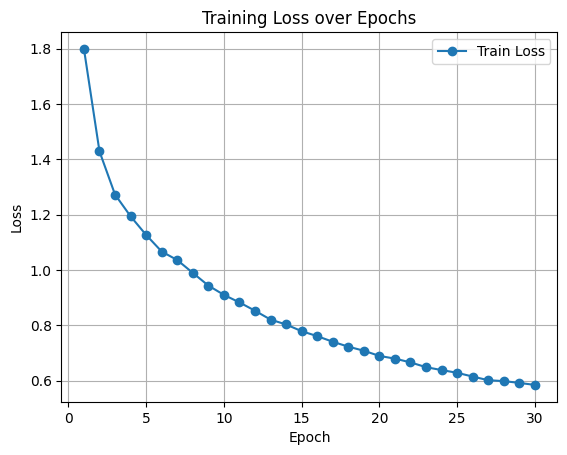

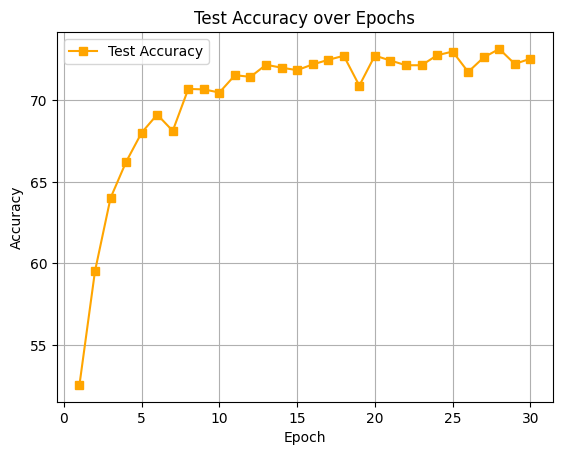

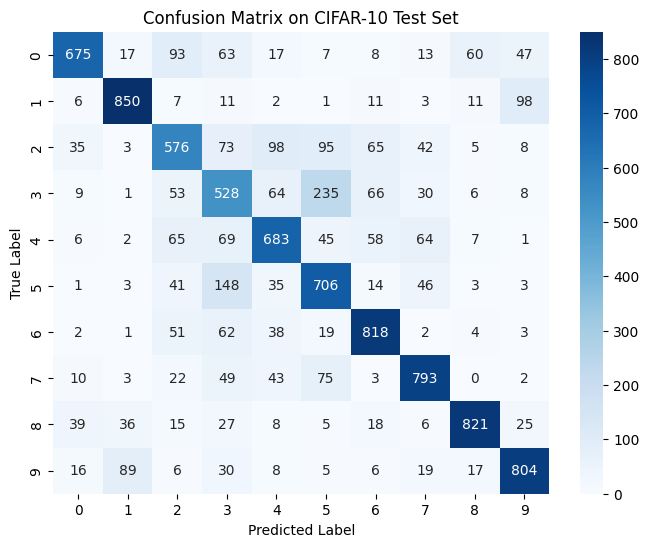

Prediction: [3 8 8 0 6 6 1 6 3 1]
Actual:     [3 8 8 0 6 6 1 6 3 1]


In [7]:
# 步骤六：模型评估
# 6.1 最后一次测试
final_acc, pred_y, true_y = test()
print(f"\nFinal Test Accuracy: {final_acc:.2f}%")

# 6.2 绘制训练loss变化曲线
plt.figure()
plt.plot(range(1, EPOCH+1), train_losses, marker='o', label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.savefig('./output/train_loss_curve.png')
plt.show()

# 6.3 绘制测试准确率变化曲线
plt.figure()
plt.plot(range(1, EPOCH+1), test_accuracies, marker='s', color='orange', label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.savefig('./output/test_accuracy_curve.png')
plt.show()

# 6.4 绘制混淆矩阵
conf_mat = confusion_matrix(true_y.numpy(), pred_y.numpy())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on CIFAR-10 Test Set")
plt.savefig('./output/confusion_matrix.png')
plt.show()

# 6.5 打印前10个预测结果
print('Prediction:', pred_y[:10].numpy())
print('Actual:    ', true_y[:10].numpy())

In [8]:
# 步骤七：保存模型与结果
# 方式二：保存完整模型结构+参数（适合快速部署）
torch.save(cnn, './output/cifar10_cnn_full.pth')

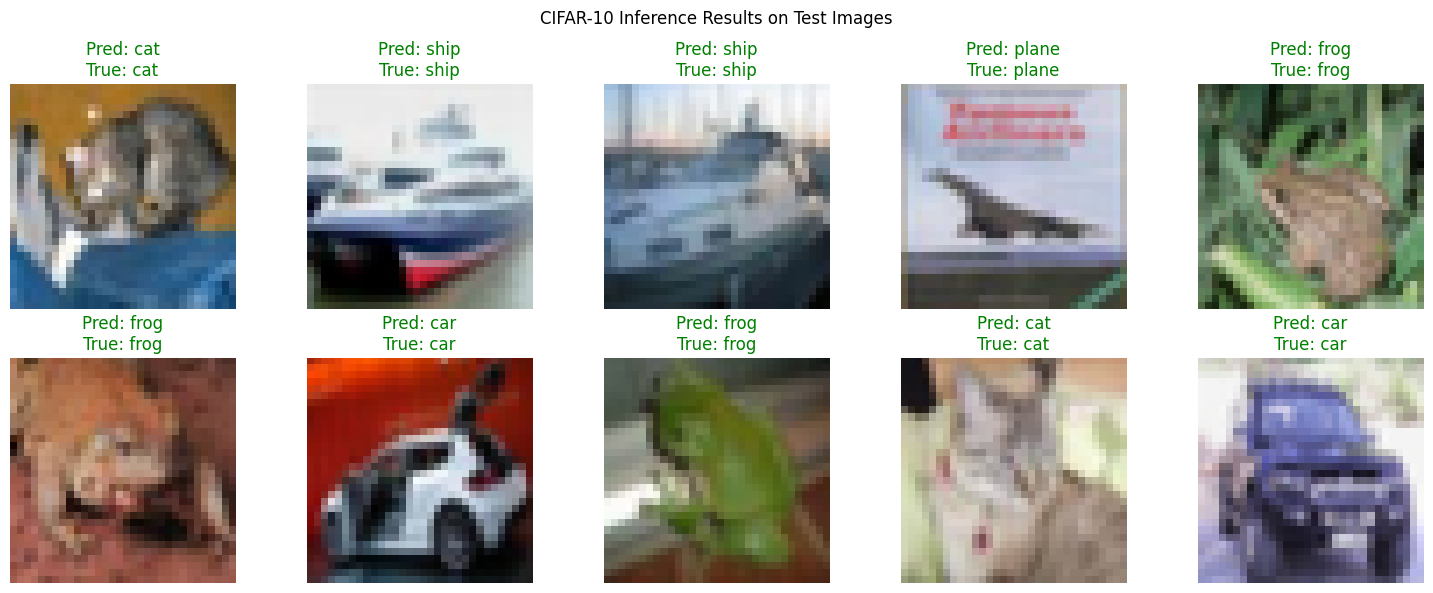

In [9]:
# 步骤八：推理结果可视化
# 8.1 CIFAR10 类别标签
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# 8.2 可视化推理函数
def visualize_cifar10_predictions(model, test_loader, device='cpu', num_images=10):
    """
    可视化模型在 CIFAR-10 测试集上的部分预测结果（RGB 彩色图）
    """
    model.eval()  # 切换到评估模式[1,5](@ref)
    shown = 0
    plt.figure(figsize=(15, 6))

    with torch.no_grad():
        for inputs, targets in test_loader:
            # 数据迁移到指定设备[1](@ref)
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # 前向传播[5](@ref)
            outputs = model(inputs)
            
            # 获取预测结果[1,6](@ref)
            _, predicted = torch.max(outputs, dim=1)

            for i in range(inputs.size(0)):
                if shown >= num_images:
                    break

                # 反归一化处理[2,5](@ref)
                img = inputs[i].cpu().numpy().transpose((1, 2, 0))  # CHW -> HWC
                img = img * 0.5 + 0.5  # 恢复原始像素范围[0,1]
                
                # 获取标签名称[2](@ref)
                true_label = classes[targets[i].item()]
                pred_label = classes[predicted[i].item()]

                # 可视化设置
                plt.subplot(2, (num_images + 1)//2, shown + 1)
                plt.imshow(img.clip(0, 1))  # 确保像素值在合理范围[5](@ref)
                plt.title(f"Pred: {pred_label}\nTrue: {true_label}", 
                         color='green' if pred_label == true_label else 'red')
                plt.axis('off')
                shown += 1

            if shown >= num_images:
                break

    plt.suptitle("CIFAR-10 Inference Results on Test Images")
    plt.tight_layout()
    plt.savefig('./output/cifar10_test_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# 8.3 执行推理可视化
visualize_cifar10_predictions(cnn, test_loader, device=DEVICE, num_images=10)